# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [37]:
import numpy as np
from scipy import misc
from importlib import reload
from labfuns import *

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

import random

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [38]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    # TODO: compute the values of prior for each class!
    # ==========================
    for idx, classname in enumerate(labels):
        prior[classname] += W[idx]
        
    prior /= np.linalg.norm(prior)
    # ==========================

    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    for jdx, classname in enumerate(classes):
        
        idx = labels == classname # Returns a true or false with the length of y
        # Or more compactly extract the indices for which y==class is true,
        # analogous to MATLAB's find
        idx = np.where(labels==classname)[0]
        xlc = X[idx,:] # Get the x for the class labels. Vectors are rows.
    
        weightsum = sum(W[idx,:])
        
        # Mean
        mu[jdx] += np.sum(X[idx,:]*W[idx,:], axis=0) / weightsum
                
        # Sigma - contains the covariance
        for dim in range(Ndims):
            totsum = 0
            for ind in idx:
                totsum += W[ind]*(X[ind][dim] - mu[jdx][dim]) ** 2
                sigma[jdx, dim, dim] = (totsum / weightsum).item()

    # ==========================

    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    for x_ind in range(Npts):
        for classname in range(Nclasses):
            term_one = (1/2)*np.log(np.linalg.det(sigma[classname]))
            
            term_two_sub_one = X[x_ind] - mu[classname]
            term_two_sub_two = np.diag(1/np.diag(sigma[classname]))
            term_two_sub_three = np.transpose(X[x_ind] - mu[classname])
            term_two = np.linalg.multi_dot([term_two_sub_one, term_two_sub_two, term_two_sub_three])
            
            term_three = np.log(prior[classname])
            
            logProb[classname, x_ind] = (- term_one - term_two + term_three).item()

    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [39]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

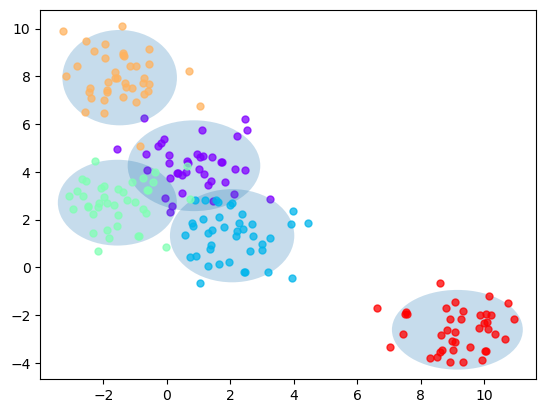

In [40]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [41]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)


Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89.2 with standard deviation 4.19


In [42]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 52.6
Trial: 10 Accuracy 61.7
Trial: 20 Accuracy 68.2
Trial: 30 Accuracy 62.3
Trial: 40 Accuracy 56.5
Trial: 50 Accuracy 63
Trial: 60 Accuracy 64.3
Trial: 70 Accuracy 62.3
Trial: 80 Accuracy 60.4
Trial: 90 Accuracy 65.6
Final mean classification accuracy  61.3 with standard deviation 3.48


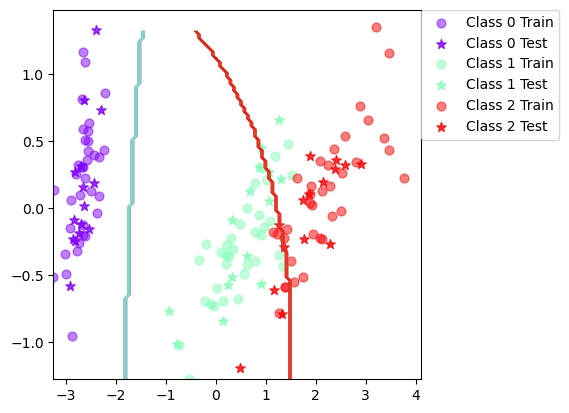

In [43]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Boosting functions to implement

The lab descriptions state what each function should do.

In [46]:
import numpy as np

def trainBoost(base_classifier, X, labels, T=10):
    Npts, Ndims = X.shape
    classifiers = []
    alphas = []
    
    # Initialize weights as a 1D array
    wCur = np.ones(Npts) / Npts  
    eps = 1e-10  # Small constant to prevent log(0)

    for i_iter in range(T):
        # Train classifier with current weights (ensure wCur is passed as 1D)
        classifier = base_classifier.trainClassifier(X, labels, wCur.reshape(-1, 1))
        classifiers.append(classifier)

        # Get predictions
        vote = classifier.classify(X)

        # Compute weighted error
        incorrect = (vote != labels).astype(int)
        error = np.sum(wCur * incorrect) / np.sum(wCur)

        # Ensure error is within valid bounds
        error = max(min(error, 1 - eps), eps)

        # Compute alpha (weight of classifier)
        curAlpha = 0.5 * np.log((1 - error) / error)
        alphas.append(curAlpha)

        # Update weights (vectorized)
        wCur *= np.exp(-curAlpha * (1 - 2 * incorrect))  
        wCur /= np.sum(wCur)  # Normalize weights

    return classifiers, alphas


In [47]:
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    if Ncomps == 1:
        return classifiers[0].classify(X)

    votes = np.zeros((Npts, Nclasses))

    for index, classifier in enumerate(classifiers):
        classified = classifier.classify(X)
        
        # Ensure indexing is valid (extract scalars)
        classified = np.asarray(classified, dtype=int)

        # Add weighted votes
        for i in range(Npts):
            votes[i, classified[i]] += alphas[index]

    return np.argmax(votes, axis=1)


The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [48]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [49]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 100
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 86.7
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 95.6
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 95.6
Final mean classification accuracy  94.8 with standard deviation 3.07


In [50]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 68.8
Trial: 10 Accuracy 77.9
Trial: 20 Accuracy 77.3
Trial: 30 Accuracy 70.1
Trial: 40 Accuracy 68.8
Trial: 50 Accuracy 68.2
Trial: 60 Accuracy 77.3
Trial: 70 Accuracy 70.8
Trial: 80 Accuracy 71.4
Trial: 90 Accuracy 82.5
Final mean classification accuracy  74.1 with standard deviation 3.73


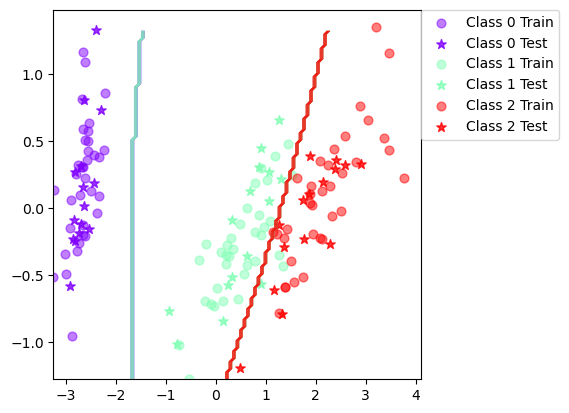

In [51]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [52]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [53]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [54]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [55]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 90.9
Trial: 20 Accuracy 87.7
Trial: 30 Accuracy 92.2
Trial: 40 Accuracy 85.7
Trial: 50 Accuracy 81.2
Trial: 60 Accuracy 91.6
Trial: 70 Accuracy 86.4
Trial: 80 Accuracy 86.4
Trial: 90 Accuracy 88.3
Final mean classification accuracy  86.8 with standard deviation 3.01


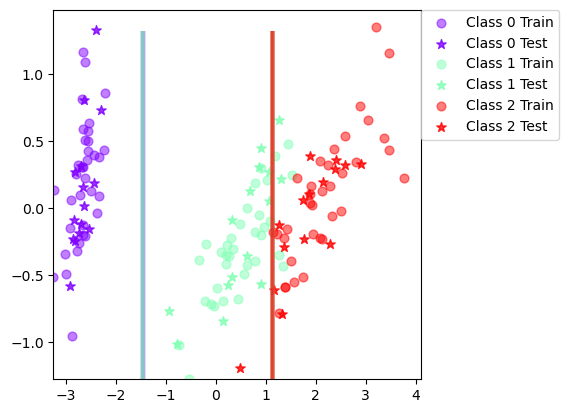

In [56]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

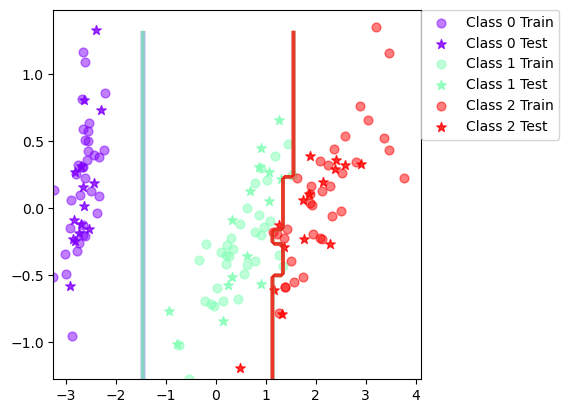

In [57]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

In [72]:


testClassifier(BoostClassifier(BayesClassifier(), T=1), dataset='iris',split=0.7)
testClassifier(BoostClassifier(BayesClassifier(), T=2), dataset='iris',split=0.7)
testClassifier(BoostClassifier(BayesClassifier(), T=5), dataset='iris',split=0.7)
testClassifier(BoostClassifier(BayesClassifier(), T=7), dataset='iris',split=0.7)

testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)
testClassifier(BoostClassifier(BayesClassifier(), T=15), dataset='iris',split=0.7)



Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89.2 with standard deviation 4.19
Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 80
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 95.6
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 88.9
Trial: 90 Accuracy 91.1
Final mean classification accuracy  90.8 with standard deviation 5.11
Trial: 0 Accuracy 100
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 95.6
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 95.6
Trial: 80 Accuracy 91.1
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.7 with standard deviation 2.96
Trial: 0 Accuracy 100
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 93.3
Trial:

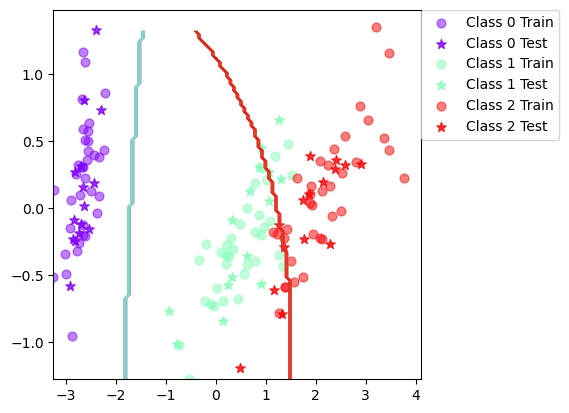

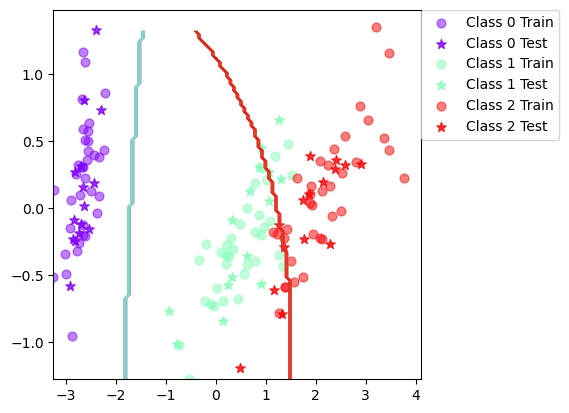

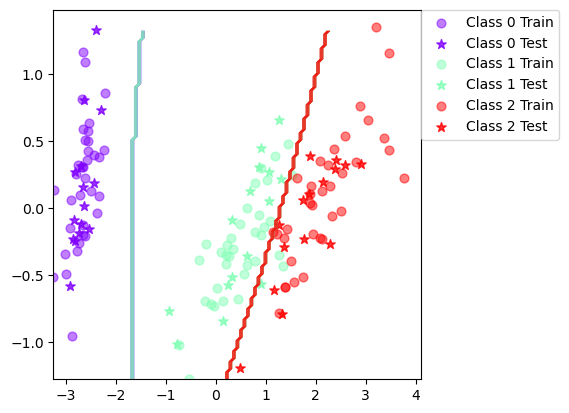

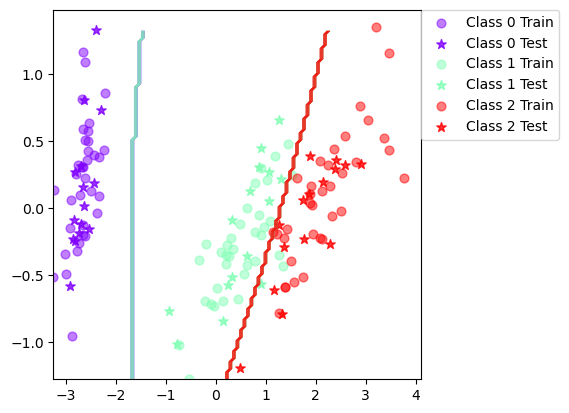

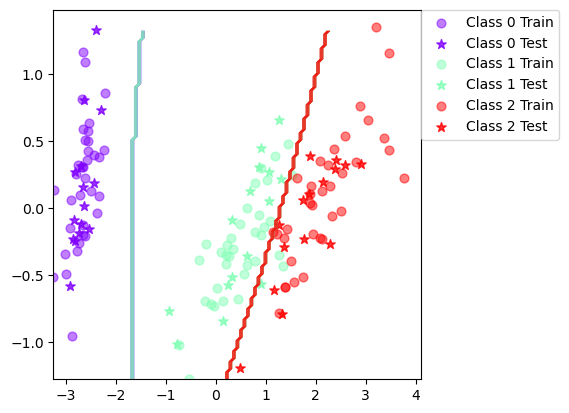

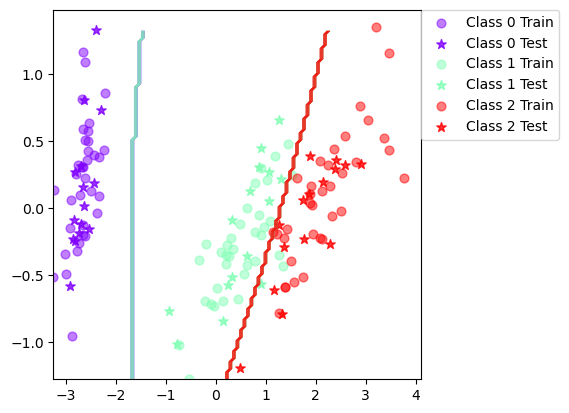

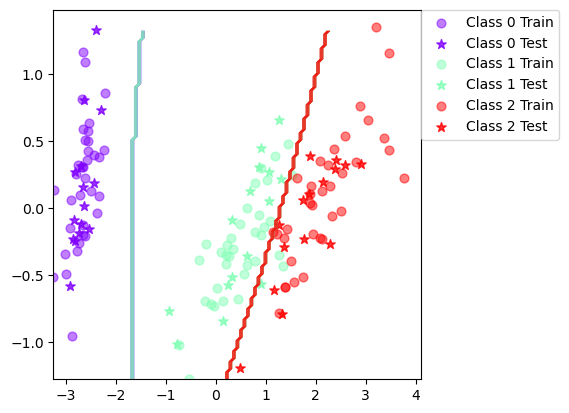

In [74]:


plotBoundary(BoostClassifier(BayesClassifier(), T=1), dataset='iris',split=0.7)
plotBoundary(BoostClassifier(BayesClassifier(), T=2), dataset='iris',split=0.7)
plotBoundary(BoostClassifier(BayesClassifier(), T=3), dataset='iris',split=0.7)
plotBoundary(BoostClassifier(BayesClassifier(), T=4), dataset='iris',split=0.7)
plotBoundary(BoostClassifier(BayesClassifier(), T=5), dataset='iris',split=0.7)
plotBoundary(BoostClassifier(BayesClassifier(), T=7), dataset='iris',split=0.7)

plotBoundary(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)



In [76]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.05)
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.1)
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.2)
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.3)
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.4)

testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.5)
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.6)

testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.8)


Trial: 0 Accuracy 86.8
Trial: 10 Accuracy 68.1
Trial: 20 Accuracy 84.7
Trial: 30 Accuracy 65.3
Trial: 40 Accuracy 87.5
Trial: 50 Accuracy 91
Trial: 60 Accuracy 90.3
Trial: 70 Accuracy 84.7
Trial: 80 Accuracy 88.2
Trial: 90 Accuracy 81.9
Final mean classification accuracy  83 with standard deviation 10.6
Trial: 0 Accuracy 94.1
Trial: 10 Accuracy 88.1
Trial: 20 Accuracy 89.6
Trial: 30 Accuracy 89.6
Trial: 40 Accuracy 91.9
Trial: 50 Accuracy 88.1
Trial: 60 Accuracy 91.1
Trial: 70 Accuracy 83.7
Trial: 80 Accuracy 89.6
Trial: 90 Accuracy 94.8
Final mean classification accuracy  90.1 with standard deviation 5.08
Trial: 0 Accuracy 90
Trial: 10 Accuracy 95.8
Trial: 20 Accuracy 90.8
Trial: 30 Accuracy 91.7
Trial: 40 Accuracy 92.5
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 95
Trial: 80 Accuracy 91.7
Trial: 90 Accuracy 90
Final mean classification accuracy  92.4 with standard deviation 2.38
Trial: 0 Accuracy 93.3
Trial: 10 Accuracy 96.2
Trial: 20 Accuracy 91.4
Trial: 30 Ac

Trial: 0 Accuracy 100
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 97.8
Trial: 60 Accuracy 95.6
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 97.8
Trial: 90 Accuracy 97.8
Final mean classification accuracy  96.4 with standard deviation 2.45
Trial: 0 Accuracy 100
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 97.8
Trial: 60 Accuracy 91.1
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  95.4 with standard deviation 2.82
Trial: 0 Accuracy 100
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 95.6
Trial: 50 Accuracy 97.8
Trial: 60 Accuracy 97.8
Trial: 70 Accuracy 95.6
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 97.8
Final mean classification accuracy  96.4 with standard deviation 2.41
Trial: 0 Accuracy 93.3
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 3

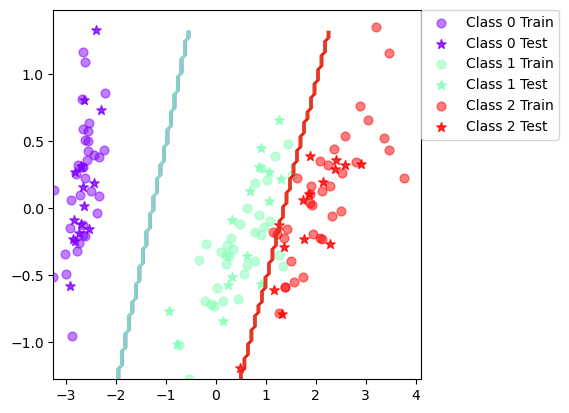

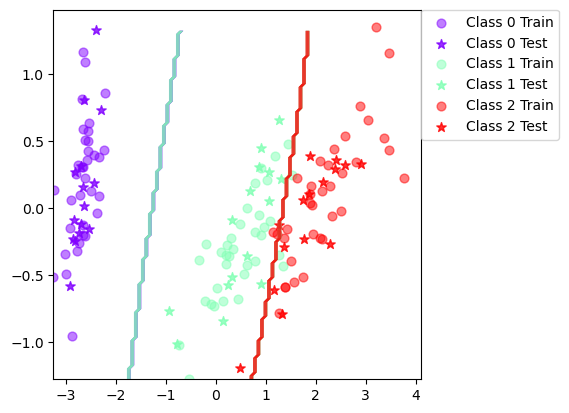

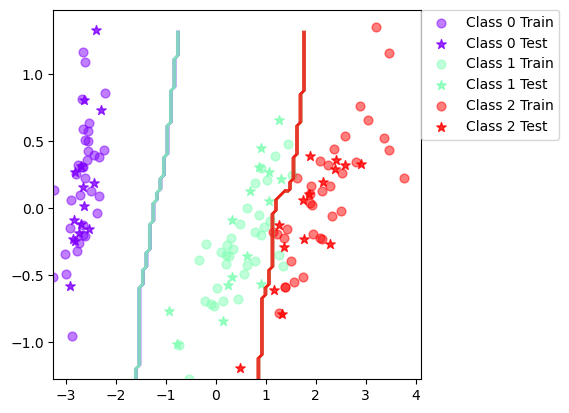

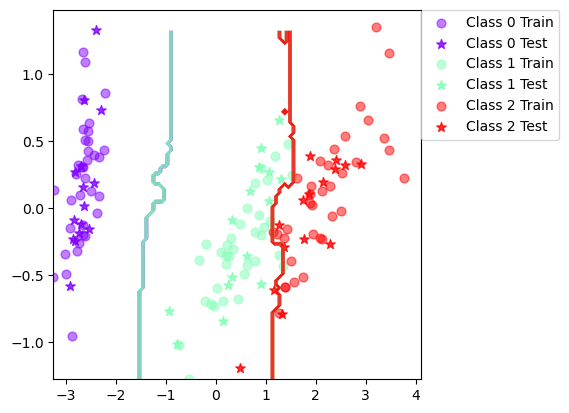

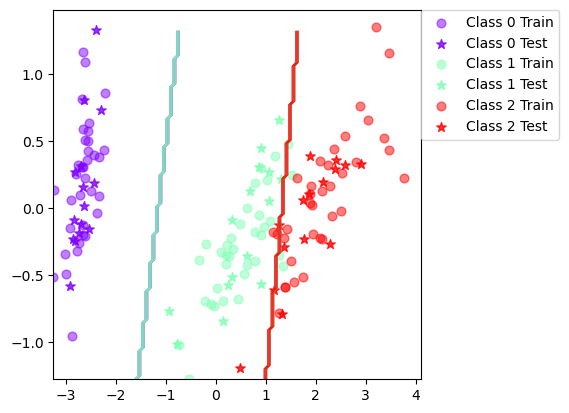

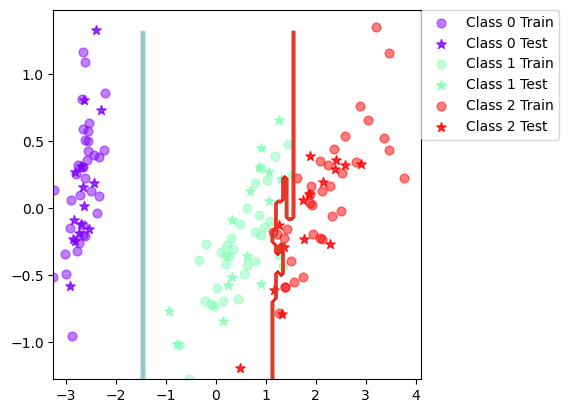

In [69]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Wrapper class to make scikit-learn classifiers compatible
class SklearnClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def trainClassifier(self, X, labels, W=None):
        self.model.fit(X, labels)  # Train using sklearn's fit()
        return self  # Return the trained instance

    def classify(self, X):
        return self.model.predict(X)  # Predict using sklearn's predict()

# Test SVM
testClassifier(SklearnClassifierWrapper(SVC(kernel='linear')), dataset='iris', split=0.7)
testClassifier(SklearnClassifierWrapper(SVC(kernel='rbf')), dataset='iris', split=0.7)  # RBF kernel

# Test KNN
testClassifier(SklearnClassifierWrapper(KNeighborsClassifier(n_neighbors=5)), dataset='iris', split=0.7)

# Test Random Forest
testClassifier(SklearnClassifierWrapper(RandomForestClassifier(n_estimators=100)), dataset='iris', split=0.7)

# Test Logistic Regression
testClassifier(SklearnClassifierWrapper(LogisticRegression(max_iter=200)), dataset='iris', split=0.7)

# Test Gradient Boosting
testClassifier(SklearnClassifierWrapper(GradientBoostingClassifier(n_estimators=100)), dataset='iris', split=0.7)


plotBoundary(SklearnClassifierWrapper(SVC(kernel='linear')), dataset='iris', split=0.7)
plotBoundary(SklearnClassifierWrapper(SVC(kernel='rbf')), dataset='iris', split=0.7)  # RBF kernel

# Test KNN
plotBoundary(SklearnClassifierWrapper(KNeighborsClassifier(n_neighbors=5)), dataset='iris', split=0.7)

# Test Random Forest
plotBoundary(SklearnClassifierWrapper(RandomForestClassifier(n_estimators=100)), dataset='iris', split=0.7)

# Test Logistic Regression
plotBoundary(SklearnClassifierWrapper(LogisticRegression(max_iter=200)), dataset='iris', split=0.7)

# Test Gradient Boosting
plotBoundary(SklearnClassifierWrapper(GradientBoostingClassifier(n_estimators=100)), dataset='iris', split=0.7)


Trial: 0 Accuracy 100
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 97.8
Trial: 60 Accuracy 95.6
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 97.8
Trial: 90 Accuracy 97.8
Final mean classification accuracy  96.4 with standard deviation 2.45
Trial: 0 Accuracy 100
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 97.8
Trial: 60 Accuracy 91.1
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  95.4 with standard deviation 2.82
Trial: 0 Accuracy 100
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 95.6
Trial: 50 Accuracy 97.8
Trial: 60 Accuracy 97.8
Trial: 70 Accuracy 95.6
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 97.8
Final mean classification accuracy  96.4 with standard deviation 2.41
Trial: 0 Accuracy 97.8
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 3

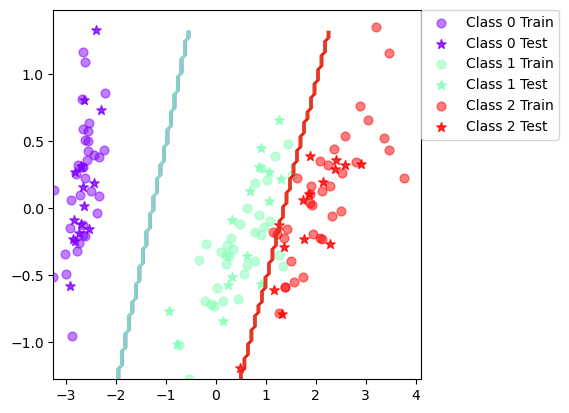

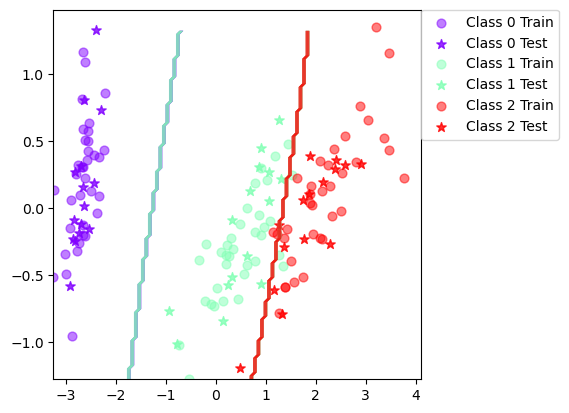

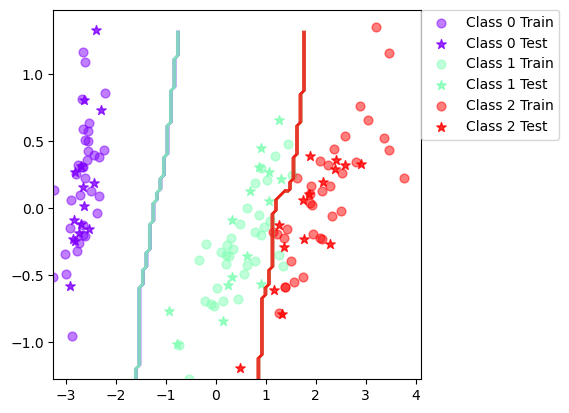

KeyboardInterrupt: 

In [70]:
# Test SVM with Boosting
testClassifier(BoostClassifier(SklearnClassifierWrapper(SVC(kernel='linear')), T=10), dataset='iris', split=0.7)
testClassifier(BoostClassifier(SklearnClassifierWrapper(SVC(kernel='rbf')), T=10), dataset='iris', split=0.7)  # RBF kernel

# Test KNN with Boosting
testClassifier(BoostClassifier(SklearnClassifierWrapper(KNeighborsClassifier(n_neighbors=5)), T=10), dataset='iris', split=0.7)

# Test Random Forest with Boosting
testClassifier(BoostClassifier(SklearnClassifierWrapper(RandomForestClassifier(n_estimators=100)), T=10), dataset='iris', split=0.7)

# Test Logistic Regression with Boosting
testClassifier(BoostClassifier(SklearnClassifierWrapper(LogisticRegression(max_iter=200)), T=10), dataset='iris', split=0.7)

# Test Gradient Boosting with Boosting
testClassifier(BoostClassifier(SklearnClassifierWrapper(GradientBoostingClassifier(n_estimators=100)), T=10), dataset='iris', split=0.7)

# Plot Decision Boundaries with Boosting

plotBoundary(BoostClassifier(SklearnClassifierWrapper(SVC(kernel='linear')), T=10), dataset='iris', split=0.7)
plotBoundary(BoostClassifier(SklearnClassifierWrapper(SVC(kernel='rbf')), T=10), dataset='iris', split=0.7)  # RBF kernel

# Plot KNN with Boosting
plotBoundary(BoostClassifier(SklearnClassifierWrapper(KNeighborsClassifier(n_neighbors=5)), T=10), dataset='iris', split=0.7)

# Plot Random Forest with Boosting
plotBoundary(BoostClassifier(SklearnClassifierWrapper(RandomForestClassifier(n_estimators=100)), T=10), dataset='iris', split=0.7)

# Plot Logistic Regression with Boosting
plotBoundary(BoostClassifier(SklearnClassifierWrapper(LogisticRegression(max_iter=200)), T=10), dataset='iris', split=0.7)

# Plot Gradient Boosting with Boosting
plotBoundary(BoostClassifier(SklearnClassifierWrapper(GradientBoostingClassifier(n_estimators=100)), T=10), dataset='iris', split=0.7)


In [77]:
testClassifier(SklearnClassifierWrapper(SVC(kernel='linear')), dataset='vowel', split=0.7)
testClassifier(SklearnClassifierWrapper(SVC(kernel='rbf')), dataset='vowel', split=0.7)  # RBF kernel

# Test KNN
testClassifier(SklearnClassifierWrapper(KNeighborsClassifier(n_neighbors=5)), dataset='vowel', split=0.7)

# Test Random Forest
testClassifier(SklearnClassifierWrapper(RandomForestClassifier(n_estimators=100)), dataset='vowel', split=0.7)

# Test Logistic Regression
testClassifier(SklearnClassifierWrapper(LogisticRegression(max_iter=200)), dataset='vowel', split=0.7)

# Test Gradient Boosting
testClassifier(SklearnClassifierWrapper(GradientBoostingClassifier(n_estimators=100)), dataset='vowel', split=0.7)


Trial: 0 Accuracy 80.5
Trial: 10 Accuracy 79.9
Trial: 20 Accuracy 80.5
Trial: 30 Accuracy 84.4
Trial: 40 Accuracy 78.6
Trial: 50 Accuracy 76
Trial: 60 Accuracy 82.5
Trial: 70 Accuracy 81.2
Trial: 80 Accuracy 78.6
Trial: 90 Accuracy 81.2
Final mean classification accuracy  79.4 with standard deviation 3.04
Trial: 0 Accuracy 76
Trial: 10 Accuracy 80.5
Trial: 20 Accuracy 85.7
Trial: 30 Accuracy 82.5
Trial: 40 Accuracy 78.6
Trial: 50 Accuracy 78.6
Trial: 60 Accuracy 81.2
Trial: 70 Accuracy 73.4
Trial: 80 Accuracy 69.5
Trial: 90 Accuracy 82.5
Final mean classification accuracy  78.1 with standard deviation 3.94
Trial: 0 Accuracy 89
Trial: 10 Accuracy 88.3
Trial: 20 Accuracy 90.3
Trial: 30 Accuracy 87
Trial: 40 Accuracy 88.3
Trial: 50 Accuracy 86.4
Trial: 60 Accuracy 89
Trial: 70 Accuracy 85.7
Trial: 80 Accuracy 79.2
Trial: 90 Accuracy 91.6
Final mean classification accuracy  86.5 with standard deviation 3.59
Trial: 0 Accuracy 94.8
Trial: 10 Accuracy 98.1
Trial: 20 Accuracy 96.1
Trial: 30 Ac

C:\Users\sally\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Trial: 20 Accuracy 67.5


C:\Users\sally\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Trial: 30 Accuracy 75.3
Trial: 40 Accuracy 66.9
Trial: 50 Accuracy 66.2
Trial: 60 Accuracy 57.8
Trial: 70 Accuracy 66.2
Trial: 80 Accuracy 64.3
Trial: 90 Accuracy 59.7
Final mean classification accuracy  65.6 with standard deviation 3.42
Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.9
Trial: 20 Accuracy 87
Trial: 30 Accuracy 83.1
Trial: 40 Accuracy 78.6
Trial: 50 Accuracy 80.5
Trial: 60 Accuracy 85.7
Trial: 70 Accuracy 88.3
Trial: 80 Accuracy 83.8
Trial: 90 Accuracy 92.2
Final mean classification accuracy  86.2 with standard deviation 3.08


#### 1️⃣ Varying the Number of Boosting Iterations (T)



Testing Boosted Decision Stump Classifier with T=1 on iris
Iteration 0: Error=0.3619, Alpha=0.2836, Weight Sum=1.0000
Accuracy: 0.6111

Testing Boosted Decision Stump Classifier with T=5 on iris
Iteration 0: Error=0.3619, Alpha=0.2836, Weight Sum=1.0000
Iteration 1: Error=0.3336, Alpha=0.3461, Weight Sum=1.0000
Iteration 2: Error=0.3028, Alpha=0.4169, Weight Sum=1.0000
Iteration 3: Error=0.3352, Alpha=0.3424, Weight Sum=1.0000
Iteration 4: Error=0.3642, Alpha=0.2785, Weight Sum=1.0000
Accuracy: 0.9222

Testing Boosted Decision Stump Classifier with T=10 on iris
Iteration 0: Error=0.3619, Alpha=0.2836, Weight Sum=1.0000
Iteration 1: Error=0.3336, Alpha=0.3461, Weight Sum=1.0000
Iteration 2: Error=0.3028, Alpha=0.4169, Weight Sum=1.0000
Iteration 3: Error=0.3352, Alpha=0.3424, Weight Sum=1.0000
Iteration 4: Error=0.3642, Alpha=0.2785, Weight Sum=1.0000
Iteration 5: Error=0.3134, Alpha=0.3921, Weight Sum=1.0000
Iteration 6: Error=0.3158, Alpha=0.3867, Weight Sum=1.0000
Iteration 7: Error

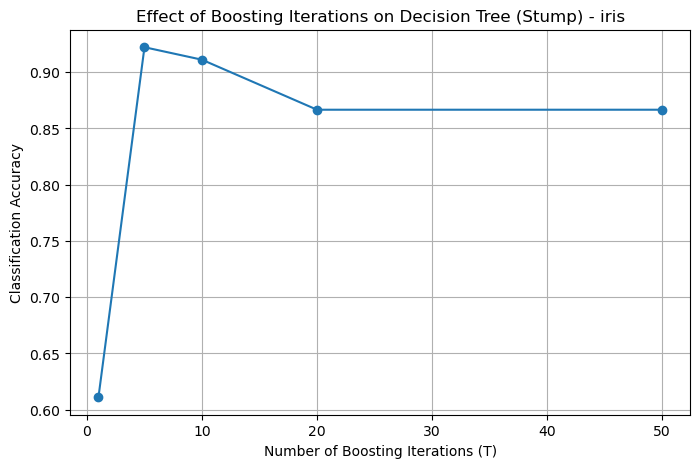


Testing Boosted Decision Stump Classifier with T=1 on vowel
Iteration 0: Error=0.8095, Alpha=-0.7235, Weight Sum=1.0000
Accuracy: 0.1111

Testing Boosted Decision Stump Classifier with T=5 on vowel
Iteration 0: Error=0.8095, Alpha=-0.7235, Weight Sum=1.0000
Iteration 1: Error=0.5000, Alpha=0.0000, Weight Sum=1.0000
Iteration 2: Error=0.5000, Alpha=-0.0000, Weight Sum=1.0000
Stopping early at T=2
Accuracy: 0.1111

Testing Boosted Decision Stump Classifier with T=10 on vowel
Iteration 0: Error=0.8095, Alpha=-0.7235, Weight Sum=1.0000
Iteration 1: Error=0.5000, Alpha=0.0000, Weight Sum=1.0000
Iteration 2: Error=0.5000, Alpha=-0.0000, Weight Sum=1.0000
Stopping early at T=2
Accuracy: 0.1111

Testing Boosted Decision Stump Classifier with T=20 on vowel
Iteration 0: Error=0.8095, Alpha=-0.7235, Weight Sum=1.0000
Iteration 1: Error=0.5000, Alpha=0.0000, Weight Sum=1.0000
Iteration 2: Error=0.5000, Alpha=-0.0000, Weight Sum=1.0000
Stopping early at T=2
Accuracy: 0.1111

Testing Boosted Decisi

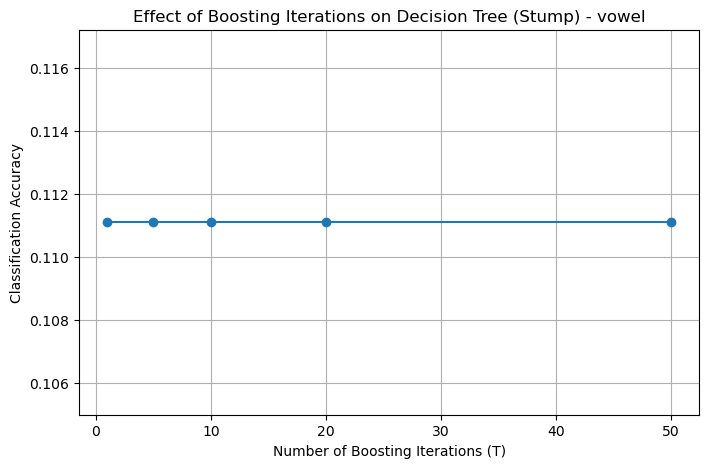

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Generate dataset
def generate_data(n_samples=300, n_features=10, n_classes=3, dataset='iris', random_state=42):
    if dataset == 'iris':
        return make_classification(n_samples=n_samples, n_features=n_features, 
                                   n_classes=n_classes, n_redundant=0, n_clusters_per_class=1, 
                                   random_state=random_state)
    elif dataset == 'vowel':  # More complex dataset
        return make_classification(n_samples=n_samples, n_features=15,  # Increased features
                                   n_classes=10, n_informative=10, n_redundant=2, 
                                   n_clusters_per_class=2, random_state=random_state)

# Boosting Classifier (Adaboost)
class BoostClassifier:
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        N = X.shape[0]
        W = np.ones(N) / N  # Initialize uniform weights
        classifiers = []
        alphas = []
        classes = np.unique(labels)  # Get unique class labels
        C = len(classes)

        prev_accuracy = 0

        for t in range(self.T):
            classifier = DecisionTreeClassifier(max_depth=1)  # Weak learner (stump)
            classifier.fit(X, labels, sample_weight=W)  # Train with weights
            classifiers.append(classifier)

            predictions = classifier.predict(X)
            incorrect = (predictions != labels).astype(int)
            error = np.dot(W, incorrect) / np.sum(W)

            # Avoid division by zero
            error = max(error, 1e-10)
            alpha = 0.5 * np.log((1 - error) / error)
            alphas.append(alpha)

            # Update weights
            W *= np.exp(-alpha * (1 - 2 * incorrect))
            W /= np.sum(W)  # Normalize

            # Monitor weight updates
            print(f"Iteration {t}: Error={error:.4f}, Alpha={alpha:.4f}, Weight Sum={np.sum(W):.4f}")

            # Stop early if accuracy stops improving
            if abs(prev_accuracy - (1 - error)) < 0.001:
                print(f"Stopping early at T={t}")
                break
            prev_accuracy = 1 - error

        self.classifiers = classifiers
        self.alphas = alphas
        self.classes = classes  # Store class labels
        self.trained = True
        return self

    def classify(self, X):
        N = X.shape[0]
        C = len(self.classes)  # Fix: Ensure correct number of classes
        votes = np.zeros((N, C))  # Fix: Correctly initialize votes array

        for alpha, classifier in zip(self.alphas, self.classifiers):
            preds = classifier.predict(X)
            for i, p in enumerate(preds):
                class_index = np.where(self.classes == p)[0][0]  # Fix: Ensure correct indexing
                votes[i, class_index] += alpha  # Weighted votes

        return self.classes[np.argmax(votes, axis=1)]  # Convert indices back to class labels

# Train and Evaluate Boosted Decision Tree Classifier
def testBoostedDecisionTree(T_values, dataset='iris'):
    accuracy_results = {}

    for T in T_values:
        print(f"\nTesting Boosted Decision Stump Classifier with T={T} on {dataset}")
        X, y = generate_data(dataset=dataset)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        classifier = BoostClassifier(DecisionTreeClassifier(max_depth=1), T=T)
        classifier = classifier.trainClassifier(X_train, y_train)
        y_pred = classifier.classify(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_results[T] = accuracy
        print(f"Accuracy: {accuracy:.4f}")

    # Plot Accuracy vs T
    plt.figure(figsize=(8, 5))
    plt.plot(T_values, list(accuracy_results.values()), marker='o', linestyle='-')
    plt.xlabel("Number of Boosting Iterations (T)")
    plt.ylabel("Classification Accuracy")
    plt.title(f"Effect of Boosting Iterations on Decision Tree (Stump) - {dataset}")
    plt.grid(True)
    plt.show()

# Run with Decision Stump (max_depth=1)
testBoostedDecisionTree([1, 5, 10, 20, 50], dataset='iris')
testBoostedDecisionTree([1, 5, 10, 20, 50], dataset='vowel')


#### 5️⃣ Checking the Impact of Sample Size on Boosting


In [ ]:
sample_sizes = [50, 100, 200, 500]  # Different dataset sizes
accuracy_results = {}

for size in sample_sizes:
    print(f"\nTesting Boosted Bayes Classifier with {size} training samples")
    X, y = getData('iris')  # Load dataset
    X_sampled, y_sampled = X[:size], y[:size]
    accuracy = testClassifier(BoostClassifier(BayesClassifier(), T=10), X_sampled, y_sampled, split=0.7)
    accuracy_results[size] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

# Plot Accuracy vs Sample Size
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, list(accuracy_results.values()), marker='o', linestyle='-')
plt.xlabel("Training Set Size")
plt.ylabel("Classification Accuracy")
plt.title("Effect of Training Set Size on Boosting")
plt.grid(True)
plt.show()


## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [59]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 82.5
Trial: 10 Accuracy 88.3
Trial: 20 Accuracy 83.3
Trial: 30 Accuracy 85.8
Trial: 40 Accuracy 86.7
Trial: 50 Accuracy 80.8
Trial: 60 Accuracy 88.3
Trial: 70 Accuracy 81.7
Trial: 80 Accuracy 79.2
Trial: 90 Accuracy 84.2
Final mean classification accuracy  84.2 with standard deviation 3.23


In [60]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 80
Trial: 10 Accuracy 75.8
Trial: 20 Accuracy 71.7
Trial: 30 Accuracy 75.8
Trial: 40 Accuracy 70
Trial: 50 Accuracy 67.5
Trial: 60 Accuracy 79.2
Trial: 70 Accuracy 75.8
Trial: 80 Accuracy 56.7
Trial: 90 Accuracy 65.8
Final mean classification accuracy  70.5 with standard deviation 6.76


You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

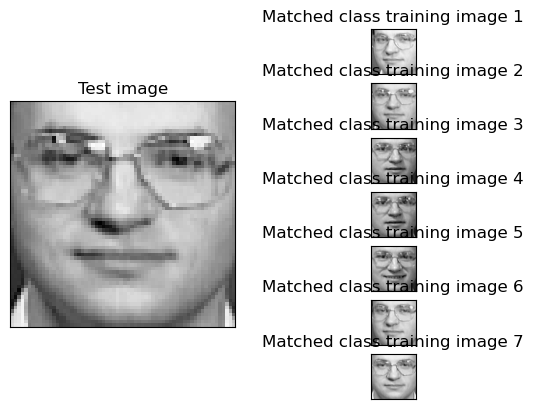

In [ ]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])


PCA Components: 10, Accuracy: 54.17%


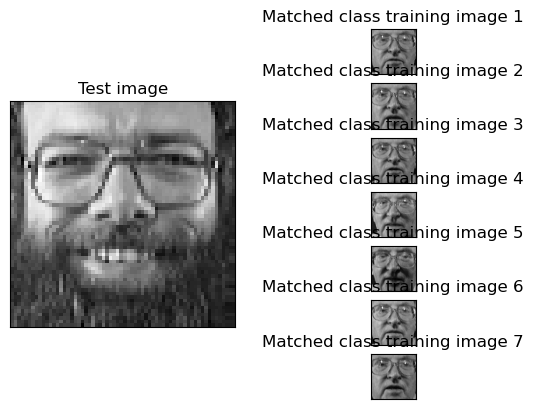

PCA Components: 20, Accuracy: 61.67%


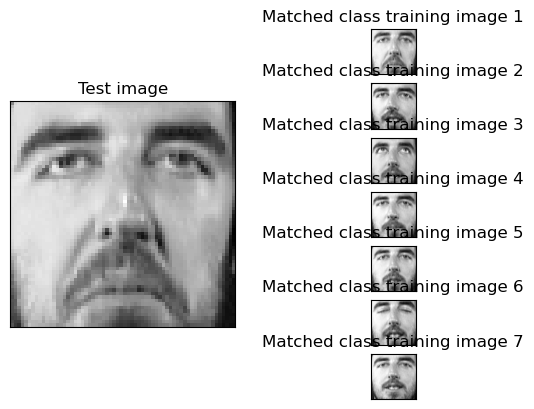

PCA Components: 30, Accuracy: 54.17%


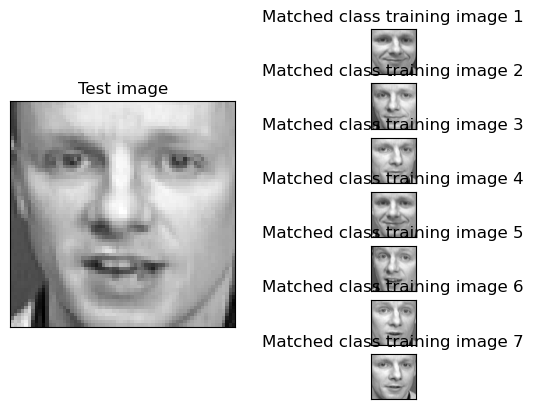

PCA Components: 50, Accuracy: 54.17%


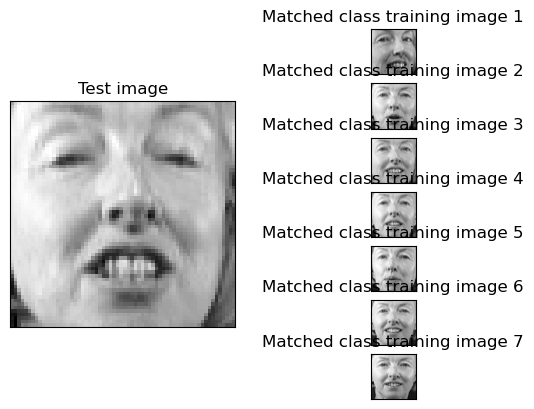

PCA Components: 70, Accuracy: 50.83%


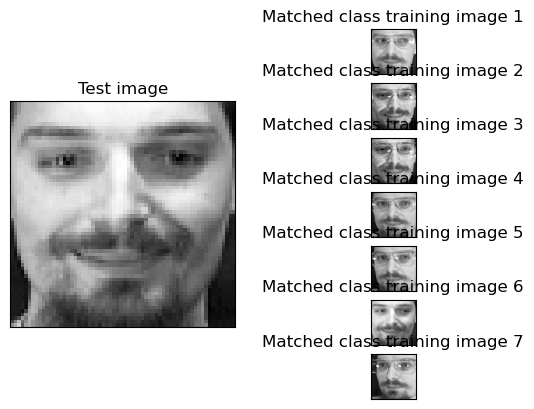

In [85]:
import random
import numpy as np
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier

# Fetch the Olivetti dataset
X, y, pcadim = fetchDataset('olivetti')

# Split into training and testing
xTr, yTr, xTe, yTe, trIdx, teIdx = trteSplitEven(X, y, 0.7)

# Test different PCA components
for n in [10, 20, 30, 50, 70]: 
    pca = decomposition.PCA(n_components=n)
    pca.fit(xTr)
    xTrpca = pca.transform(xTr)
    xTepca = pca.transform(xTe)

    # Train Boosted Decision Tree classifier
    classifier = BoostClassifier(SklearnClassifierWrapper(DecisionTreeClassifier()), T=10).trainClassifier(xTrpca, yTr)
    yPr = classifier.classify(xTepca)

    # Print accuracy for the number of PCA components
    print(f"PCA Components: {n}, Accuracy: {np.mean(yPr == yTe) * 100:.2f}%")

    # Choose a test point to visualize
    testind = random.randint(0, xTe.shape[0] - 1)
    
    # Visualize the test image with matched training images
    visualizeOlivettiVectors(xTr[yTr == yPr[testind], :], xTe[testind, :])


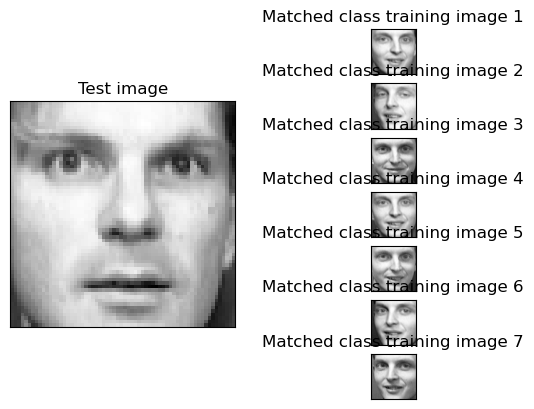

True Label: 17, Predicted Label: 39


In [83]:
import random
import numpy as np
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier

# Fetch the Olivetti dataset
X, y, pcadim = fetchDataset('olivetti')

# Split into training and testing
xTr, yTr, xTe, yTe, trIdx, teIdx = trteSplitEven(X, y, 0.7)

# Apply PCA to reduce dimension
pca = decomposition.PCA(n_components=20)
pca.fit(xTr)
xTrpca = pca.transform(xTr)
xTepca = pca.transform(xTe)

# Train Boosted Decision Tree classifier
classifier = BoostClassifier(SklearnClassifierWrapper(DecisionTreeClassifier()), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)

# Get indices of misclassified images
misclassified_idx = np.where(yPr != yTe)[0]  

if len(misclassified_idx) > 0:
    testind = random.choice(misclassified_idx)  # Pick a random misclassified image
    
    # Visualize the misclassified image with its predicted matched class
    visualizeOlivettiVectors(xTr[yTr == yPr[testind], :], xTe[testind, :])
    print(f"True Label: {yTe[testind]}, Predicted Label: {yPr[testind]}")
else:
    print("No misclassified images found!")


Accuracy without PCA: 50.83%


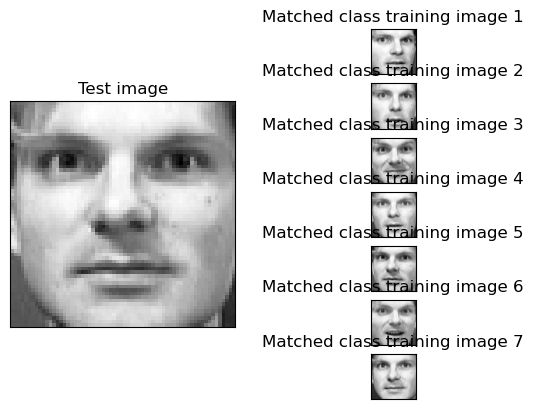

In [84]:
import random
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Fetch the Olivetti dataset
X, y, pcadim = fetchDataset('olivetti')

# Split into training and testing
xTr, yTr, xTe, yTe, trIdx, teIdx = trteSplitEven(X, y, 0.7)

# Train Boosted Decision Tree classifier WITHOUT PCA
classifier_no_pca = BoostClassifier(SklearnClassifierWrapper(DecisionTreeClassifier()), T=10).trainClassifier(xTr, yTr)
yPr_no_pca = classifier_no_pca.classify(xTe)

# Print accuracy without PCA
print(f"Accuracy without PCA: {np.mean(yPr_no_pca == yTe) * 100:.2f}%")

# Choose a test point to visualize
testind = random.randint(0, xTe.shape[0] - 1)

# Visualize the test image with its matched training images
visualizeOlivettiVectors(xTr[yTr == yPr_no_pca[testind], :], xTe[testind, :])
